In [1]:
import copy
import os
import time
import traceback
from contextlib import contextmanager
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

!pip install nyaggle
from nyaggle.validation import StratifiedGroupKFold
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

     |████████████████████████████████| 52 kB 717 kB/s 


In [2]:
TOKEN2INT = {x: i for i, x in enumerate('().ACGUBEHIMSX')}
PRED_COLS_SCORED = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
PRED_COLS = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

DATA_DIR = "../input/stanford-covid-vaccine/"
REPLACE_DATA_PATH = "../input/eternafold/eternafold_mfe.csv"
PRIMARY_BPPS_DIR = "../input/eternafold/bpps/"
SECONDARY_BPPS_DIR = "../input/bpps-by-viennat70/"
NFOLDS = 7
BATCH_SIZE = 64
TRAIN_EPOCHS = 140

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class Conv(nn.Module):
    def __init__(self, d_in, d_out, kernel_size, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv1d(d_in, d_out, kernel_size=kernel_size, padding=kernel_size // 2)
        self.bn = nn.BatchNorm1d(d_out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        return self.dropout(self.relu(self.bn(self.conv(src))))


class ResidualGraphAttention(nn.Module):
    def __init__(self, d_model, kernel_size, dropout):
        super().__init__()
        self.conv1 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
        self.conv2 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
        self.relu = nn.ReLU()

    def forward(self, src, attn):
        h = self.conv2(self.conv1(torch.bmm(src, attn)))
        return self.relu(src + h)
    

class SEResidual(nn.Module):
    def __init__(self, d_model, kernel_size, dropout):
        super().__init__()
        self.conv1 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
        self.conv2 = Conv(d_model, d_model, kernel_size=kernel_size, dropout=dropout)
        self.relu = nn.ReLU()
        self.se = SELayer(d_model)

    def forward(self, src):
        h = self.conv2(self.conv1(src))
        return self.se(self.relu(src + h))


class FusedEmbedding(nn.Module):
    def __init__(self, n_emb):
        super().__init__()
        self.emb = nn.Embedding(len(TOKEN2INT), n_emb)
        self.n_emb = n_emb

    def forward(self, src, se):
        # src: [batch, seq, feature]
        # se: [batch, seq]
        embed = self.emb(src)
        embed = embed.reshape((-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        embed = torch.cat((embed, se), 2)

        return embed

    @property
    def d_out(self):
        d_emb = 3 * self.n_emb
        d_feat = 2 * 5  # max, sum, 2nd, 3rd, nb_count
        return d_emb + d_feat
    

class ConvModel(nn.Module):
    def __init__(self, d_emb=50, d_model=256, dropout=0.6, dropout_res=0.4, dropout_emb=0.0,
                 kernel_size_conv=7, kernel_size_gc=7):
        super().__init__()

        self.embedding = FusedEmbedding(d_emb)
        self.dropout = nn.Dropout(dropout_emb)
        self.conv = Conv(self.embedding.d_out, d_model, kernel_size=3, dropout=dropout)

        self.block1 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
        self.block2 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
        self.block3 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
        self.block4 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)
        self.block5 = SEResidual(d_model, kernel_size=kernel_size_conv, dropout=dropout_res)

        self.attn1 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)
        self.attn2 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)
        self.attn3 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)
        self.attn4 = ResidualGraphAttention(d_model, kernel_size=kernel_size_gc, dropout=dropout_res)

        self.linear = nn.Linear(d_model, len(PRED_COLS))

    def forward(self, 
                src: torch.Tensor, 
                features: torch.Tensor, 
                bpps: torch.Tensor, 
                adj: torch.Tensor):
        # src: [batch, seq, 3]
        # features: [batch, seq, 10]
        # bpps: [batch, seq, seq, 2]
        # adj: [batch, seq, seq]
        
        x = self.dropout(self.embedding(src, features))
        x = x.permute([0, 2, 1])  # [batch, d-emb, seq]
        
        x = self.conv(x)
        x = self.block1(x)
        x = self.attn1(x, adj)
        x = self.block2(x)
        x = self.attn2(x, adj)
        x = self.block3(x)
        x = self.attn3(x, bpps[:, :, :, 0])
        x = self.attn4(x, bpps[:, :, :, 1])
        x = self.block4(x)
        x = self.block5(x)

        x = x.permute([0, 2, 1])  # [batch, seq, features]
        out = self.linear(x)

        out = torch.clamp(out, -0.5, 1e8)

        return out
    


class WRMSELoss(nn.Module):
    """Вычисление квадратного корня из среднего квадрата ошибки"""
    def __init__(self):
        super().__init__()

    def forward(self, yhat, y, sample_weight=None):
        l = (yhat - y) ** 2

        if sample_weight is not None:
            l = l * sample_weight.unsqueeze(dim=1)

        return torch.sqrt(torch.mean(l))


class ColWiseLoss(nn.Module):
    def __init__(self, base_loss):
        super().__init__()
        self.base_loss = base_loss
        self.len_scored = 68

    def forward(self, yhat, y, column_weight=None, sample_weight=None):
        score = 0
        for i in range(len(PRED_COLS)):
            s = self.base_loss(
                yhat[:, :self.len_scored, i], 
                y[:, :self.len_scored, i], 
                sample_weight
            ) / len(PRED_COLS)
            
            if column_weight is not None:
                s *= column_weight[i]
                
            score += s
        return score


class MCRMSELoss(ColWiseLoss):
    def __init__(self):
        super().__init__(WRMSELoss())

In [5]:
@contextmanager
def timer(name):
    s = time.time()
    yield
    print(f"{name}: {time.time() - s:.3f}sec")


def pandas_list_to_array(df: pd.DataFrame) -> np.ndarray:
    return np.transpose(
        np.array(
            df.values
                .tolist()
        ),
        (0, 2, 1)
    )


def preprocess_inputs(df: pd.DataFrame) -> np.ndarray:
    return pandas_list_to_array(
        df[['sequence', 'structure', 'predicted_loop_type']]
            .applymap(lambda seq: [TOKEN2INT[x] for x in seq])
    )


def build_adj_matrix(src_df: pd.DataFrame, normalize: bool = True) -> np.ndarray:
    n = len(src_df['structure'].iloc[0])
    mat = np.zeros((len(src_df), n, n))
    start_token_indices = []

    for r, structure in tqdm(enumerate(src_df['structure'])):
        for i, token in enumerate(structure):
            if token == "(":
                start_token_indices.append(i)
            elif token == ")":
                j = start_token_indices.pop()
                mat[r, i, j] = 1
                mat[r, j, i] = 1

    assert len(start_token_indices) == 0

    if normalize:
        mat = mat / (mat.sum(axis=2, keepdims=True) + 1e-8)

    return mat


def replace_data(train_df: pd.DataFrame, test_df: pd.DataFrame, replace_data_dir: str):
    print(f"using data from {replace_data_dir}")

    aux = pd.read_csv(replace_data_dir)
    del train_df['structure']
    del train_df['predicted_loop_type']
    del test_df['structure']
    del test_df['predicted_loop_type']
    train_df = pd.merge(train_df, aux, on='id', how='left')
    test_df = pd.merge(test_df, aux, on='id', how='left')
    assert len(train_df) == 2400
    assert len(test_df) == 3634
    assert train_df['structure'].isnull().sum() == 0
    assert train_df['predicted_loop_type'].isnull().sum() == 0
    assert test_df['structure'].isnull().sum() == 0
    assert test_df['predicted_loop_type'].isnull().sum() == 0
    return train_df, test_df


def load_bpps(df: pd.DataFrame, data_dir: str) -> np.ndarray:
    return np.array([np.load(f'{data_dir}bpps/{did}.npy') for did in df.id])


def make_bpps_features(bpps_list: List[np.ndarray]) -> np.ndarray:
    ar = []

    for b in bpps_list:
        ar.append(b.sum(axis=2))

        # max, 2ndmax, 3rdmax
        bpps_sorted = np.sort(b, axis=2)[:, :, ::-1]
        ar.append(bpps_sorted[:, :, 0])
        ar.append(bpps_sorted[:, :, 1])
        ar.append(bpps_sorted[:, :, 2])

        # number of nonzero
        bpps_nb_mean = 0.077522  # mean of bpps_nb across all training data
        bpps_nb_std = 0.08914  # std of bpps_nb across all training data
        nb = (b > 0).sum(axis=2)
        nb = (nb - bpps_nb_mean) / bpps_nb_std
        ar.append(nb)

    return np.transpose(np.array(ar), (1, 2, 0))


def make_dataset(device, x: np.ndarray, y: np.ndarray,
                 bpps_primary: np.ndarray,
                 bpps_secondary: np.ndarray,
                 adj_matrix: np.ndarray,
                 prediction_mask: np.ndarray,
                 signal_to_noise=None):
    x = copy.deepcopy(x)
    if y is not None:
        y = copy.deepcopy(y)
    bpps_primary = copy.deepcopy(bpps_primary)
    bpps_secondary = copy.deepcopy(bpps_secondary)
    bpps = np.concatenate([
        bpps_primary[:, :, :, np.newaxis],
        bpps_secondary[:, :, :, np.newaxis]
    ], axis=-1)

    adj_matrix = copy.deepcopy(adj_matrix)
    prediction_mask = copy.deepcopy(prediction_mask)

    if y is not None:
        y = np.clip(y, -0.5, 10)
        mask = np.abs(y).max(axis=(1, 2)) < 10
    else:
        mask = [True] * len(x)

    tensors = [
        torch.LongTensor(x[mask]),
        torch.Tensor(make_bpps_features([bpps_primary[mask], bpps_secondary[mask]])),
        torch.Tensor(bpps[mask]),
        torch.Tensor(adj_matrix[mask]),
        torch.Tensor(prediction_mask[mask])
    ]

    if y is not None:
        tensors.append(torch.Tensor(y[mask]))
        
        sample_weight = np.clip(np.log(signal_to_noise[mask] + 1.1) / 2, 0, 100)
        tensors.append(torch.Tensor(sample_weight))

    return torch.utils.data.TensorDataset(*[t.to(device) for t in tensors])


def make_dataset_from_df(device, df: pd.DataFrame, bpps_dir: str, secondary_bpps_dir: str):
    assert df['seq_scored'].nunique() == 1

    inputs = preprocess_inputs(df)
    bpps = load_bpps(df, bpps_dir)
    adj = build_adj_matrix(df)
    secondary_bpps = load_bpps(df, secondary_bpps_dir)

    mask = np.zeros((len(df), len(df['sequence'].iloc[0]), len(PRED_COLS)))
    mask[:, :df['seq_scored'].iloc[0], :] = 1

    return make_dataset(device, inputs, None, bpps, secondary_bpps, adj, mask)


def dist(s1: str, s2: str) -> int:
    return sum([c1 != c2 for c1, c2 in zip(s1, s2)])


def get_distance_matrix(s: pd.Series) -> np.ndarray:
    mat = np.zeros((len(s), len(s)))

    for i in tqdm(range(len(s))):
        for j in range(i + 1, len(s)):
            mat[i, j] = mat[j, i] = dist(s[i], s[j])
    return mat


def batch_predict(model: nn.Module, loader: DataLoader) -> np.ndarray:
    y_preds = np.zeros((len(loader.dataset), loader.dataset[0][0].shape[0], len(PRED_COLS)))

    for i, (x_batch, x_se, x_bpps, x_adj, y_mask) in enumerate(loader):
        y_pred = model(x_batch, x_se, x_bpps, x_adj).detach() * y_mask
        y_preds[i * loader.batch_size:(i + 1) * loader.batch_size, :, :] = y_pred.cpu().numpy()
        
    return y_preds


def calc_loss(y_true: np.ndarray, y_pred: np.ndarray):
    """Нахождение MCRMSE метрики для 3 оцениваемых значений из 5
    (в соревновании оцениваются не все предсказываемые метрики"""
    err_w_valid = [1 if s in PRED_COLS_SCORED else 0 for s in PRED_COLS]
    raw = MCRMSELoss()(torch.Tensor(y_pred), torch.Tensor(y_true), err_w_valid).item()
    
    return raw * len(PRED_COLS) / len(PRED_COLS_SCORED)

In [6]:
def train_model(model, train_loader, valid_loader, y_valid,
                train_epochs, train_loss, verbose=True,
                model_path='model'):
    params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    print(f'number of params: {params}')

    err_w_train_1 = [1 if s in PRED_COLS_SCORED else 1.0 for s in PRED_COLS]
    err_w_train_2 = [1 if s in PRED_COLS_SCORED else 0.01 for s in PRED_COLS]

    criterion_train = train_loss
    optimizer = torch.optim.Adam(model.parameters())

    losses = []
    val_losses = []
    y_preds_best = None

    for epoch in range(train_epochs):
        start_time = time.time()

        model.train()
        avg_loss = 0.

        for x_batch, x_se, x_bpps, x_adj, y_mask, y_batch, sample_weight in tqdm(train_loader, disable=True):
            y_pred = model(x_batch, x_se, x_bpps, x_adj) * y_mask
            
            # use 5 columns for the first 30 epoch
            w = err_w_train_1 if epoch < 30 else err_w_train_2
            
            loss = criterion_train(y_pred, y_batch, w, sample_weight)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        model.eval()
        y_preds = batch_predict(model, valid_loader)
        mcloss = calc_loss(y_valid, y_preds)
        val_losses.append(mcloss)
        
        s = f"{epoch:03d}: trn:{avg_loss:.4f}, clean={mcloss:.4f}, {time.time() - start_time:.2f}s"

        losses.append(avg_loss)
        # Вычисление минимального значения функции потерь
        if np.min(val_losses) == mcloss:
            y_preds_best = y_preds
            torch.save(model.state_dict(), model_path)

        if (isinstance(verbose, bool) and verbose) or (verbose > 0 and (epoch % verbose == 0)):
            print(s)

    print(f'min val_loss: {np.min(val_losses):.4f} at {np.argmin(val_losses) + 1} epoch')

    # recover best weight
    model.load_state_dict(torch.load(model_path))

    if not verbose:
        return np.min(val_losses)

    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    ax[0].plot(np.arange(1, len(losses) + 1), losses)
    ax[1].plot(np.arange(1, len(val_losses) + 1), val_losses)

    for i, p in enumerate(PRED_COLS):
        ax[2].scatter(y_valid[:, :, i].flatten(), y_preds_best[:, :, i].flatten(), alpha=0.5)

    ax[0].legend(['train'])
    ax[1].legend(['valid(clean)'])
    ax[2].legend(PRED_COLS)
    ax[2].set_xlabel('y_true')
    ax[2].set_ylabel('y_predicted')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[2].set_xlabel('y_true(clean)')
    ax[2].set_ylabel('y_predicted(clean)')
    plt.show()

    return np.min(val_losses)

## Load data

In [7]:
with timer("load data"):
    train_df = pd.read_json(DATA_DIR + 'train.json', lines=True)
    test_df = pd.read_json(DATA_DIR + 'test.json', lines=True)
    sample_df = pd.read_csv(DATA_DIR + 'sample_submission.csv')

    train_df, test_df = replace_data(train_df, test_df, REPLACE_DATA_PATH)

with timer("clustering"):
    # use clustering based on edit distance
    seq_dist = get_distance_matrix(train_df['sequence'])
    clf = AgglomerativeClustering(n_clusters=None, 
                                  distance_threshold=20, 
                                  affinity='precomputed',
                                  linkage='average')
    group_index = clf.fit_predict(seq_dist)

using data from ../input/eternafold/eternafold_mfe.csv
load data: 1.253sec


100%|██████████| 2400/2400 [01:54<00:00, 20.91it/s] 


clustering: 115.014sec


In [8]:
with timer("preprocess"):
    public_df = test_df.query("seq_length != 130")
    private_df = test_df.query("seq_length == 130")

    x = preprocess_inputs(train_df)
    y = pandas_list_to_array(train_df[PRED_COLS])

    label_mask = np.ones_like(y)
    pad = np.zeros((y.shape[0], x.shape[1] - y.shape[1], y.shape[2]))
    y = np.concatenate((y, pad), axis=1)
    label_mask = np.concatenate((label_mask, pad), axis=1)

    assert x.shape[1] == y.shape[1]

    train_adj = build_adj_matrix(train_df)
    primary_bpps = load_bpps(train_df, PRIMARY_BPPS_DIR)    
    secondary_bpps = load_bpps(train_df, SECONDARY_BPPS_DIR)

    public_data = make_dataset_from_df(device, public_df, PRIMARY_BPPS_DIR, SECONDARY_BPPS_DIR)
    private_data = make_dataset_from_df(device, private_df, PRIMARY_BPPS_DIR, SECONDARY_BPPS_DIR)

2400it [00:00, 13419.75it/s]
629it [00:00, 12905.36it/s]
3005it [00:00, 3820.70it/s]


preprocess: 51.052sec


## Training

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


fold 0
number of params: 8437953
000: trn:0.3987, clean=0.6372, 3.78s
005: trn:0.2672, clean=0.2738, 2.49s
010: trn:0.2435, clean=0.2628, 2.47s
015: trn:0.2291, clean=0.2479, 2.49s
020: trn:0.2210, clean=0.2478, 2.55s
025: trn:0.2132, clean=0.2355, 2.65s
030: trn:0.1226, clean=0.2308, 2.49s
035: trn:0.1171, clean=0.2307, 2.47s
040: trn:0.1140, clean=0.2316, 2.49s
045: trn:0.1123, clean=0.2339, 2.52s
050: trn:0.1102, clean=0.2300, 2.57s
055: trn:0.1083, clean=0.2321, 2.59s
060: trn:0.1062, clean=0.2299, 2.52s
065: trn:0.1050, clean=0.2291, 2.46s
070: trn:0.1024, clean=0.2295, 2.70s
075: trn:0.1018, clean=0.2302, 2.53s
080: trn:0.1001, clean=0.2286, 2.59s
085: trn:0.0996, clean=0.2286, 2.63s
090: trn:0.0980, clean=0.2308, 2.49s
095: trn:0.0965, clean=0.2285, 2.45s
100: trn:0.0960, clean=0.2316, 2.48s
105: trn:0.0948, clean=0.2280, 2.45s
110: trn:0.0936, clean=0.2362, 2.56s
115: trn:0.0928, clean=0.2282, 2.65s
120: trn:0.0926, clean=0.2298, 2.52s
125: trn:0.0919, clean=0.2337, 2.50s
130: 

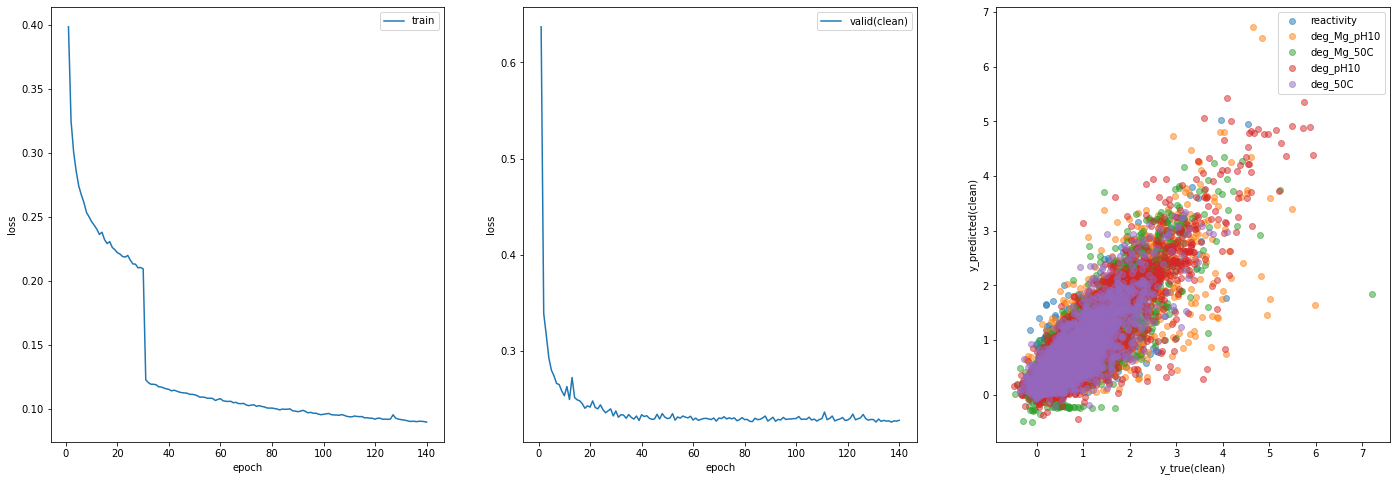

elapsed: 369.3sec
fold 1
number of params: 8437953
000: trn:0.3957, clean=0.3681, 2.53s
005: trn:0.2637, clean=0.2744, 2.46s
010: trn:0.2409, clean=0.2594, 2.48s
015: trn:0.2291, clean=0.2477, 2.60s
020: trn:0.2181, clean=0.2405, 2.71s
025: trn:0.2110, clean=0.2372, 2.47s
030: trn:0.1203, clean=0.2361, 2.50s
035: trn:0.1160, clean=0.2312, 2.48s
040: trn:0.1136, clean=0.2314, 2.57s
045: trn:0.1108, clean=0.2281, 2.60s
050: trn:0.1083, clean=0.2262, 2.48s
055: trn:0.1067, clean=0.2239, 2.47s
060: trn:0.1051, clean=0.2277, 2.52s
065: trn:0.1034, clean=0.2217, 2.59s
070: trn:0.1020, clean=0.2254, 2.77s
075: trn:0.1004, clean=0.2231, 2.45s
080: trn:0.0990, clean=0.2248, 2.47s
085: trn:0.0977, clean=0.2232, 2.47s
090: trn:0.0965, clean=0.2219, 2.55s
095: trn:0.0950, clean=0.2240, 2.71s
100: trn:0.0945, clean=0.2209, 2.58s
105: trn:0.0931, clean=0.2221, 2.49s
110: trn:0.0920, clean=0.2207, 2.48s
115: trn:0.0915, clean=0.2224, 2.50s
120: trn:0.0913, clean=0.2215, 2.52s
125: trn:0.0903, clean=0

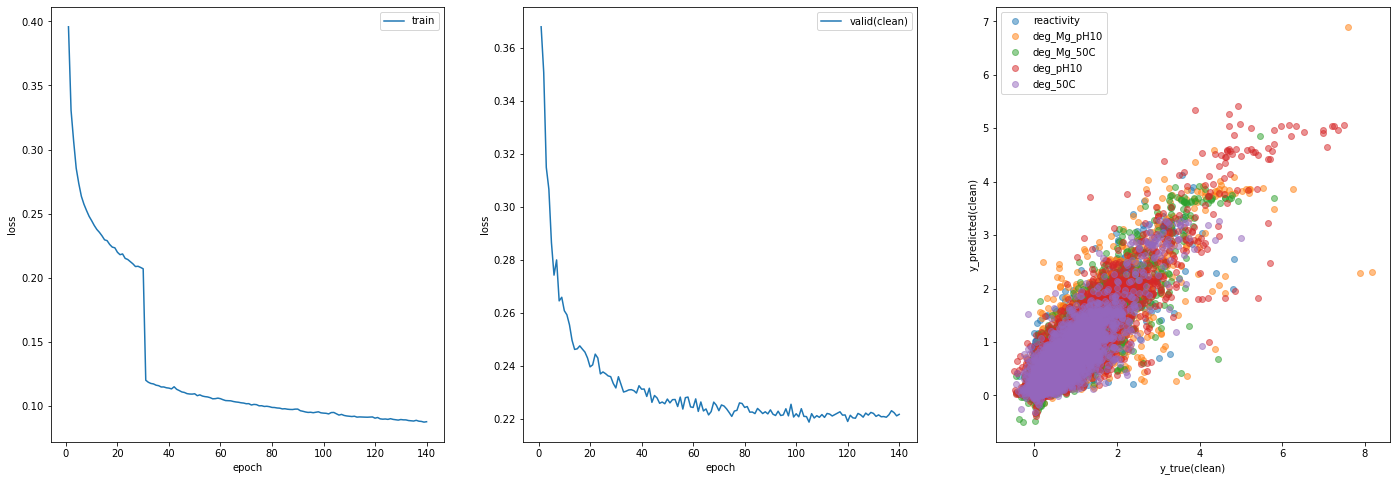

elapsed: 369.1sec
fold 2
number of params: 8437953
000: trn:0.4088, clean=0.5355, 2.71s
005: trn:0.2705, clean=0.2842, 2.52s
010: trn:0.2437, clean=0.2658, 2.48s
015: trn:0.2290, clean=0.2512, 2.97s
020: trn:0.2195, clean=0.2531, 2.60s
025: trn:0.2133, clean=0.2416, 2.70s
030: trn:0.1215, clean=0.2410, 2.48s
035: trn:0.1172, clean=0.2369, 2.51s
040: trn:0.1138, clean=0.2345, 2.54s
045: trn:0.1107, clean=0.2320, 2.68s
050: trn:0.1088, clean=0.2348, 2.67s
055: trn:0.1078, clean=0.2315, 2.52s
060: trn:0.1063, clean=0.2329, 2.97s
065: trn:0.1037, clean=0.2291, 2.55s
070: trn:0.1033, clean=0.2313, 2.49s
075: trn:0.1009, clean=0.2281, 2.65s
080: trn:0.0998, clean=0.2298, 2.51s
085: trn:0.0986, clean=0.2334, 2.66s
090: trn:0.0967, clean=0.2295, 2.53s
095: trn:0.0957, clean=0.2306, 2.49s
100: trn:0.0951, clean=0.2299, 2.65s
105: trn:0.0937, clean=0.2297, 2.61s
110: trn:0.0937, clean=0.2299, 2.50s
115: trn:0.0921, clean=0.2277, 2.57s
120: trn:0.0912, clean=0.2281, 2.48s
125: trn:0.0912, clean=0

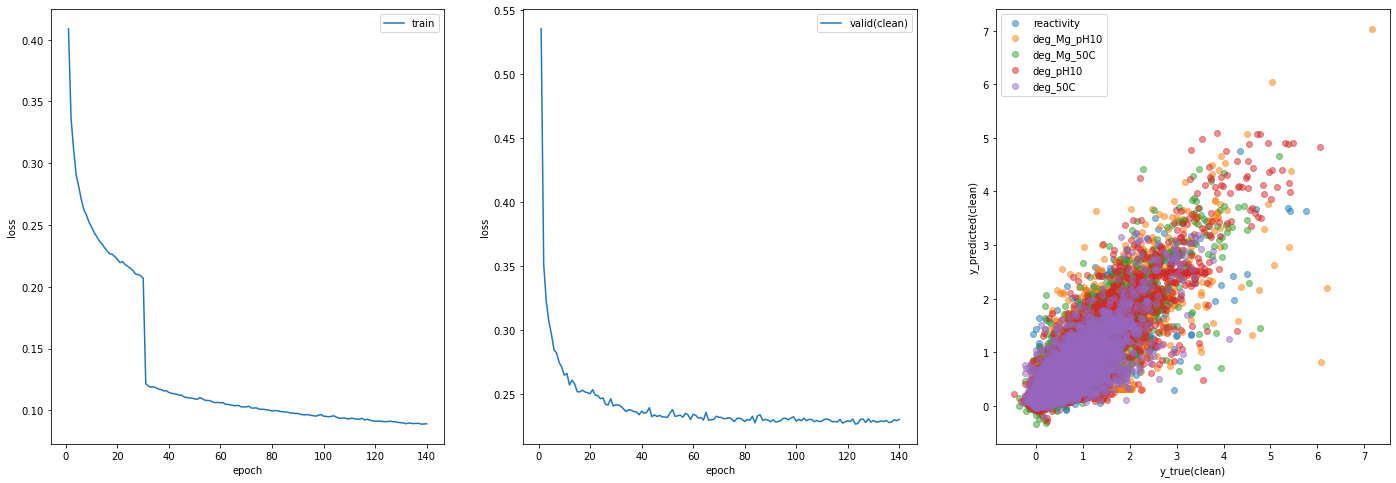

elapsed: 373.6sec
fold 3
number of params: 8437953
000: trn:0.3965, clean=0.5987, 2.59s
005: trn:0.2679, clean=0.2957, 2.46s
010: trn:0.2417, clean=0.2719, 3.10s
015: trn:0.2281, clean=0.2642, 2.47s
020: trn:0.2171, clean=0.2581, 2.50s
025: trn:0.2109, clean=0.2522, 2.62s
030: trn:0.1210, clean=0.2503, 2.62s
035: trn:0.1148, clean=0.2446, 2.81s
040: trn:0.1122, clean=0.2446, 2.47s
045: trn:0.1104, clean=0.2460, 2.46s
050: trn:0.1078, clean=0.2422, 2.51s
055: trn:0.1063, clean=0.2459, 2.72s
060: trn:0.1044, clean=0.2472, 2.47s
065: trn:0.1022, clean=0.2464, 2.51s
070: trn:0.1013, clean=0.2413, 2.46s
075: trn:0.0995, clean=0.2430, 2.50s
080: trn:0.0982, clean=0.2410, 2.74s
085: trn:0.0970, clean=0.2425, 2.47s
090: trn:0.0966, clean=0.2411, 2.50s
095: trn:0.0948, clean=0.2416, 2.49s
100: trn:0.0946, clean=0.2424, 2.47s
105: trn:0.0929, clean=0.2404, 2.51s
110: trn:0.0921, clean=0.2396, 2.57s
115: trn:0.0912, clean=0.2421, 2.62s
120: trn:0.0908, clean=0.2422, 2.46s
125: trn:0.0896, clean=0

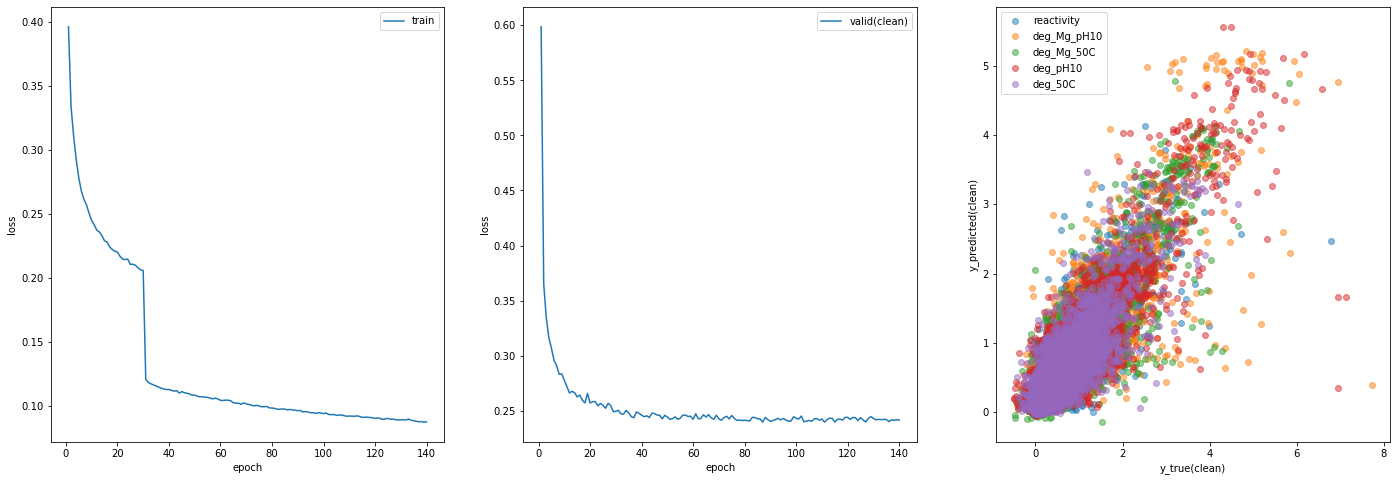

elapsed: 368.2sec
fold 4
number of params: 8437953
000: trn:0.4050, clean=0.5972, 2.49s
005: trn:0.2850, clean=0.2775, 2.56s
010: trn:0.2450, clean=0.2525, 2.59s
015: trn:0.2292, clean=0.2408, 2.55s
020: trn:0.2185, clean=0.2333, 2.46s
025: trn:0.2122, clean=0.2344, 2.50s
030: trn:0.1203, clean=0.2315, 2.58s
035: trn:0.1162, clean=0.2363, 2.53s
040: trn:0.1136, clean=0.2373, 2.59s
045: trn:0.1106, clean=0.2333, 2.45s
050: trn:0.1082, clean=0.2289, 2.47s
055: trn:0.1059, clean=0.2272, 2.51s
060: trn:0.1042, clean=0.2328, 2.51s
065: trn:0.1025, clean=0.2330, 2.48s
070: trn:0.1010, clean=0.2259, 2.61s
075: trn:0.0993, clean=0.2295, 2.46s
080: trn:0.0981, clean=0.2281, 2.51s
085: trn:0.0967, clean=0.2273, 2.47s
090: trn:0.0961, clean=0.2289, 2.57s
095: trn:0.0952, clean=0.2323, 2.49s
100: trn:0.0941, clean=0.2307, 2.65s
105: trn:0.0924, clean=0.2289, 2.48s
110: trn:0.0919, clean=0.2336, 2.49s
115: trn:0.0913, clean=0.2292, 2.60s
120: trn:0.0903, clean=0.2303, 2.47s
125: trn:0.0893, clean=0

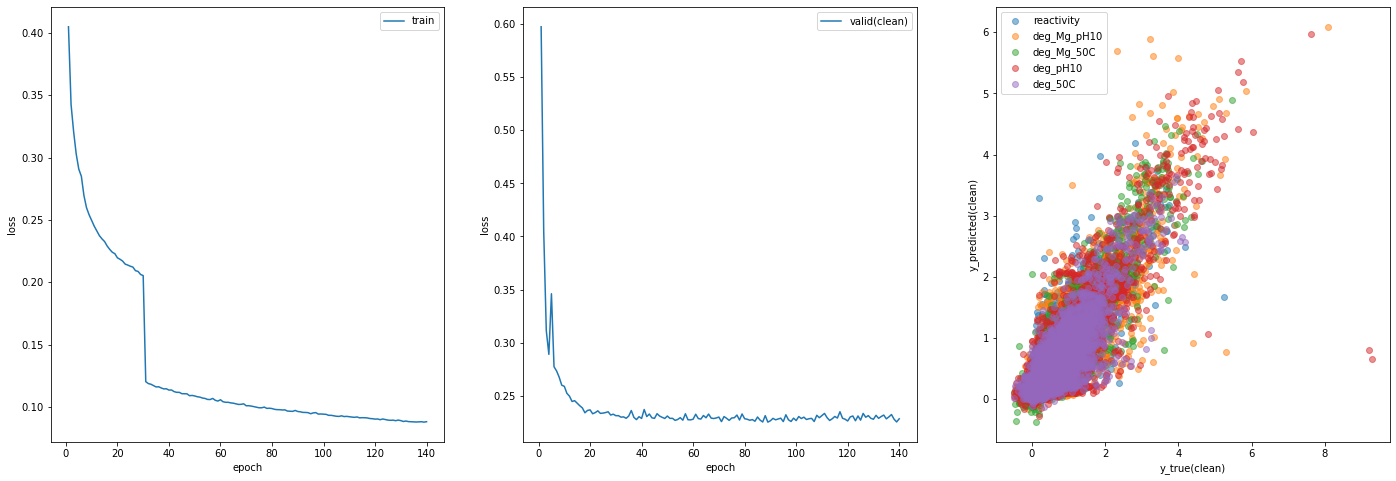

elapsed: 369.4sec
fold 5
number of params: 8437953
000: trn:0.4159, clean=0.4129, 2.61s
005: trn:0.2724, clean=0.2842, 2.56s
010: trn:0.2465, clean=0.2613, 2.62s
015: trn:0.2304, clean=0.2526, 2.46s
020: trn:0.2205, clean=0.2514, 2.54s
025: trn:0.2126, clean=0.2434, 3.01s
030: trn:0.1215, clean=0.2389, 2.47s
035: trn:0.1171, clean=0.2399, 2.47s
040: trn:0.1139, clean=0.2369, 2.46s
045: trn:0.1117, clean=0.2358, 2.44s
050: trn:0.1095, clean=0.2374, 2.78s
055: trn:0.1067, clean=0.2409, 2.48s
060: trn:0.1059, clean=0.2361, 2.46s
065: trn:0.1038, clean=0.2331, 2.44s
070: trn:0.1023, clean=0.2381, 2.45s
075: trn:0.1003, clean=0.2341, 2.50s
080: trn:0.0992, clean=0.2335, 2.60s
085: trn:0.0980, clean=0.2318, 2.61s
090: trn:0.0969, clean=0.2350, 2.46s
095: trn:0.0950, clean=0.2331, 2.62s
100: trn:0.0942, clean=0.2332, 2.46s
105: trn:0.0935, clean=0.2319, 2.46s
110: trn:0.0925, clean=0.2374, 2.54s
115: trn:0.0923, clean=0.2331, 2.61s
120: trn:0.0910, clean=0.2347, 2.51s
125: trn:0.0908, clean=0

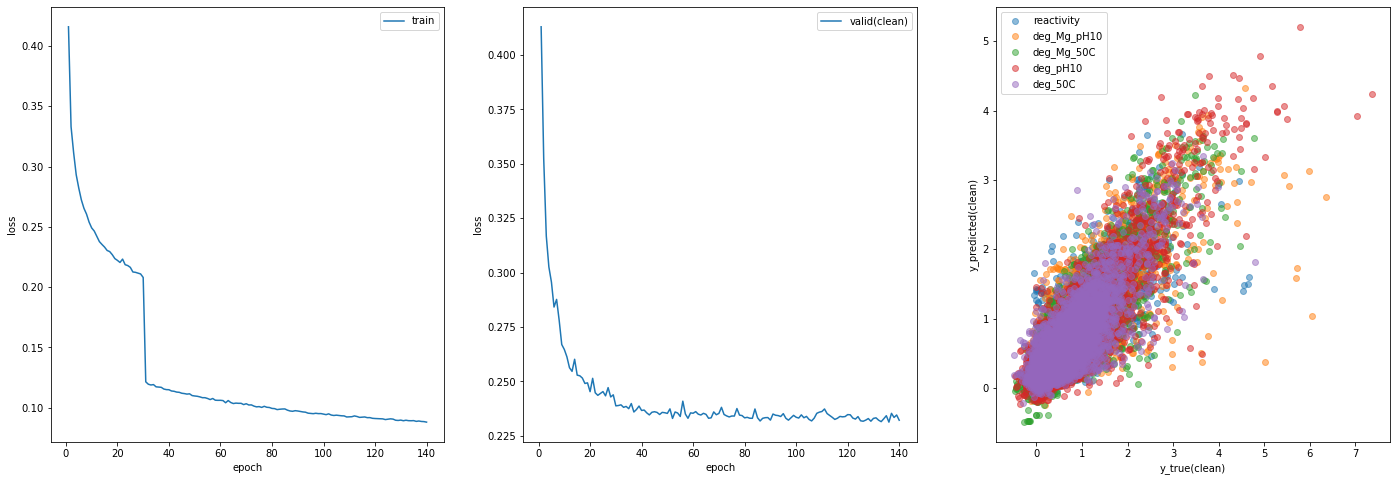

elapsed: 367.6sec
fold 6
number of params: 8437953
000: trn:0.3912, clean=0.4379, 2.75s
005: trn:0.2699, clean=0.2751, 2.56s
010: trn:0.2450, clean=0.2487, 2.63s
015: trn:0.2314, clean=0.2426, 2.54s
020: trn:0.2189, clean=0.2328, 2.48s
025: trn:0.2131, clean=0.2340, 2.50s
030: trn:0.1203, clean=0.2300, 2.48s
035: trn:0.1163, clean=0.2283, 2.50s
040: trn:0.1133, clean=0.2345, 2.86s
045: trn:0.1104, clean=0.2285, 2.75s
050: trn:0.1088, clean=0.2311, 2.52s
055: trn:0.1057, clean=0.2285, 2.47s
060: trn:0.1044, clean=0.2303, 2.51s
065: trn:0.1040, clean=0.2285, 2.72s
070: trn:0.1014, clean=0.2313, 2.58s
075: trn:0.1001, clean=0.2290, 2.53s
080: trn:0.0992, clean=0.2291, 2.49s
085: trn:0.0983, clean=0.2282, 2.48s
090: trn:0.0967, clean=0.2298, 2.60s
095: trn:0.0952, clean=0.2296, 2.66s
100: trn:0.0941, clean=0.2293, 2.47s
105: trn:0.0939, clean=0.2293, 2.47s
110: trn:0.0924, clean=0.2316, 2.48s
115: trn:0.0924, clean=0.2293, 2.81s
120: trn:0.0909, clean=0.2272, 2.47s
125: trn:0.0899, clean=0

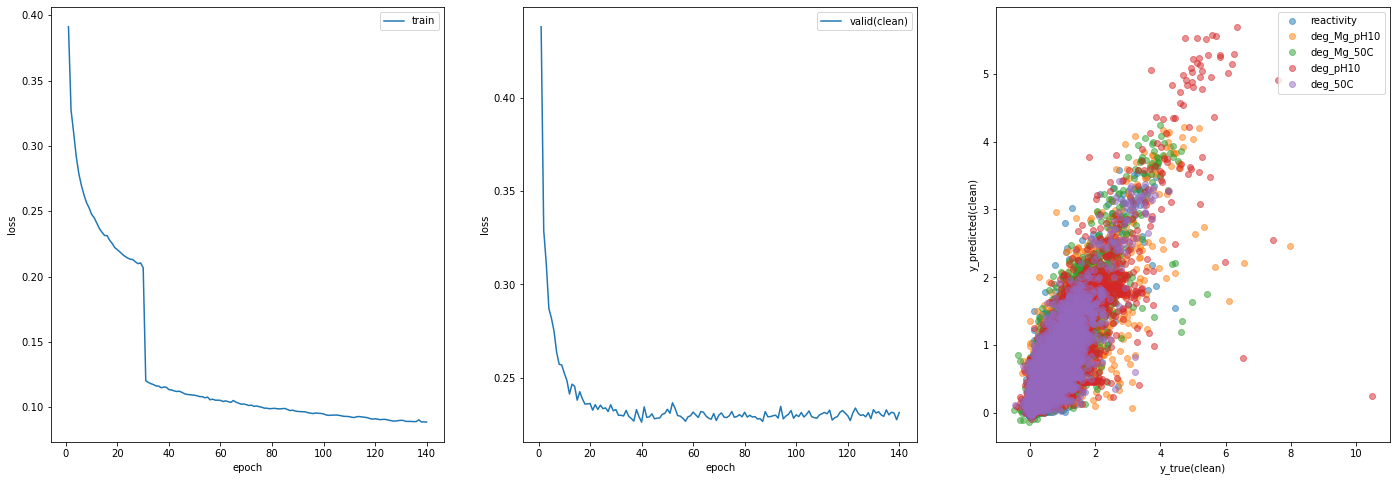

elapsed: 368.6sec
oof(all):  0.6457
oof(clean):  0.2277
[0.22575105230013529, 0.21893834074338278, 0.22604987025260925, 0.2396129568417867, 0.22540311018625894, 0.2313190201918284, 0.22636952499548593]


In [9]:
kf = StratifiedGroupKFold(NFOLDS, random_state=42, shuffle=True)

pred_oof = np.zeros_like(y)
pred_public = np.zeros((len(public_data), len(public_df['sequence'].iloc[0]), len(PRED_COLS)))
pred_private = np.zeros((len(private_data), len(private_df['sequence'].iloc[0]), len(PRED_COLS)))

public_loader = DataLoader(public_data, batch_size=128, shuffle=False)
private_loader = DataLoader(private_data, batch_size=128, shuffle=False)

clean_idx = [i for i in range(len(train_df)) if train_df['SN_filter'].iloc[i]]
sn_mask = train_df['SN_filter'] == 1

criterion_train = MCRMSELoss()
model_path = "model_fold{}"

losses = []

for i, (train_index, valid_index) in enumerate(kf.split(x, train_df['SN_filter'], groups=group_index)):
    print(f'fold {i}')
    model = ConvModel().to(device)
    s = time.time()

    train_data = make_dataset(device, x[train_index], y[train_index],
                              primary_bpps[train_index], secondary_bpps[train_index],
                              train_adj[train_index],
                              label_mask[train_index],
                              signal_to_noise=train_df['signal_to_noise'][train_index].values)

    valid_index_c = [v for v in valid_index if v in clean_idx]
    valid_data_clean = make_dataset(device, x[valid_index_c], None,
                                    primary_bpps[valid_index_c],
                                    secondary_bpps[valid_index_c],
                                    train_adj[valid_index_c],
                                    label_mask[valid_index_c])
    valid_data_noisy = make_dataset(device, x[valid_index], None,
                                  primary_bpps[valid_index],
                                  secondary_bpps[valid_index],
                                  train_adj[valid_index],
                                  label_mask[valid_index])

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader_clean = DataLoader(valid_data_clean, batch_size=128, shuffle=False)
    valid_loader_noisy = DataLoader(valid_data_noisy, batch_size=128, shuffle=False)

    loss = train_model(model, 
                       train_loader, 
                       valid_loader_clean, 
                       y[valid_index_c], 
                       TRAIN_EPOCHS, 
                       criterion_train,
                       verbose=5, 
                       model_path=model_path.format(i))

    losses.append(loss)

    # predict
    pred_oof[valid_index] = batch_predict(model, valid_loader_noisy)
    pred_public += batch_predict(model, public_loader) / NFOLDS
    pred_private += batch_predict(model, private_loader) / NFOLDS

    print(f'elapsed: {time.time() - s:.1f}sec')

oof_score = calc_loss(y, pred_oof)
print(f'oof(all): {oof_score: .4f}')

oof_score = calc_loss(y[sn_mask], pred_oof[sn_mask])
print(f'oof(clean): {oof_score: .4f}')

# make submission and oof
preds_ls = []

for df, preds in [(public_df, pred_public), (private_df, pred_private)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=PRED_COLS)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)
preds_df.head()

submission = sample_df[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)

np.save('oof', pred_oof)
np.save('public', pred_public)
np.save('private', pred_private)

print(losses)